In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, Arc
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import KFold
import random
import copy

In [2]:
shots_df = pd.read_csv("data/shot_logs.csv")
better_shots_df = shots_df[["CLOSEST_DEFENDER_PLAYER_ID","player_id","LOCATION","W","FINAL_MARGIN","SHOT_NUMBER","PERIOD","SHOT_CLOCK","DRIBBLES","TOUCH_TIME","SHOT_DIST","PTS_TYPE","CLOSE_DEF_DIST","FGM"]]
input_size = 13

class MakeDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features.values,dtype=torch.float32)
        self.labels = torch.tensor(labels.values,dtype=torch.float32)
        
    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

def shots_data_processing(df):
    # select columns, numerical encoding
    df_outcome = df["FGM"]
    if "LOCATION" in df.columns:
        df.loc[:,"LOCATION"] = df["LOCATION"] == 'H'
        df.loc[:,"LOCATION"] = df.loc[:,"LOCATION"].astype(int)
    if "W" in df.columns:
        df.loc[:,"W"] = df["W"] == 'H'
        df.loc[:,"W"] = df.loc[:,"W"].astype(int)
    df = df.astype("float64")
    # target encoding for player id, closest defender id
    if "player_id" in df.columns:
        df.loc[:,"player_id"] = df["player_id"].map(df.groupby("player_id")["FGM"].mean())
    if "CLOSEST_DEFENDER_PLAYER_ID" in df.columns:
        df.loc[:,"CLOSEST_DEFENDER_PLAYER_ID"] = df["CLOSEST_DEFENDER_PLAYER_ID"].map(df.groupby("CLOSEST_DEFENDER_PLAYER_ID")["FGM"].mean())

    # scaling to [-1,1]
    def scaling_func(x):
        if not (x.max() == 1 and x.min() == 0):
            return 2 * (x - x.min()) / (x.max() - x.min()) - 1
        return x
    df_scaled = df.apply(scaling_func).astype("float64")

    df_scaled = df_scaled.fillna(0)

    return MakeDataset(df_scaled.drop("FGM",axis=1),df_outcome)

In [3]:
class DeepnnModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, num_hidden_layers):
        super(DeepnnModel, self).__init__()
        self.num_hidden_layers = num_hidden_layers
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_layer_size))
        for _ in range(num_hidden_layers):
            self.layers.append(nn.Linear(hidden_layer_size, hidden_layer_size))
        self.layers.append(nn.Linear(hidden_layer_size, 1))
        self.relu = nn.LeakyReLU(negative_slope=0.01, inplace=False)
        self._initialize_weights()

    def forward(self, x):
        for i in range(len(self.layers) - 1):  # Exclude the last layer for activation
            x = self.relu(self.layers[i](x))
        x = self.layers[-1](x)
        return x

    def _initialize_weights(self):
        # Apply He initialization to all layers with ReLU/LeakyReLU activations
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='leaky_relu')
                nn.init.zeros_(layer.bias)
        
class LogRegModel(nn.Module):
    def __init__(self,input_size):
        super(LogRegModel,self).__init__()
        self.fc1 = nn.Linear(input_size,1)
    def forward(self,x):
        f1 = self.fc1(x)
        return f1

In [11]:
def train(initialized_model, train_data, num_epochs, print_fold_progress = False, epoch_progress_bar = False, print_roc_curve = True):
    # 10 folds for cross validation
    k_folds = 10
    kf = KFold(n_splits=k_folds, shuffle=True)

    acc = []
    auc_scores = []
    auc_labels = []
    auc_probs = []
    # Store and return models for test set validation
    models = []

    batch_size = 64

    # k-fold cross validation
    for fold, (train_idx, val_idx) in enumerate(kf.split(train_data)):
        if print_fold_progress: print(f"Fold {fold + 1}/{k_folds}")

        train_split = train_data.iloc[train_idx]
        val_split = train_data.iloc[val_idx]

        processed_train_data = shots_data_processing(train_split)
        trainloader = DataLoader(processed_train_data, batch_size, shuffle=True)

        # BCEWithLogitsLoss(), Adam
        # Very important to deepcopy the model instead of shallow copying
        model = copy.deepcopy(initialized_model)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        progress_bar = lambda x:x
        # tqdm is acting up, doesn't seem to be working well
        if epoch_progress_bar: progress_bar = tqdm
        for epoch in progress_bar(range(num_epochs)):
            model.train()
            for i, data in enumerate(trainloader, 0):
                inputs, labels = data
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(-1), labels)
                loss.backward()
                optimizer.step()

        models.append(model)
        with torch.no_grad():
            correct, total, probs, labels = validate(model,val_split,False,False)
            acc.append(correct / total)
            auc = roc_auc_score(labels, probs)
            auc_scores.append(roc_auc_score(labels,probs))
            auc_labels.extend(labels)
            auc_probs.extend(probs)

    # Calculate and print average accuracy and AUC across all folds
    print(f"Average accuracy: {sum(acc) / len(acc)}")
    print(f"Average AUC: {sum(auc_scores) / len(auc_scores)}")

    if print_roc_curve:
        # Plot the final ROC curve based on all the labels and probabilities across all folds
        fpr, tpr, thresholds = roc_curve(auc_labels, auc_probs)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='b', label=f'ROC curve (AUC = {sum(auc_scores) / len(auc_scores):.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

    return acc, auc_scores, models

def validate(model,val_data,print_roc_curve=True,print_acc_auc=True,use_optimal_threshold=True):
    # With smaller batch sizes, there may be no true/false cases at all, causing an error when calculating tpr/fpr
    batch_size = 1000

    processed_val_data = shots_data_processing(val_data)
    valloader = DataLoader(processed_val_data, batch_size, shuffle=False)

    correct, total = 0, 0
    probs, labels = [], []

    with torch.no_grad():
        for data in valloader:
            features, outcome = data
            outputs = model(features)
            probabilities = torch.sigmoid(outputs.squeeze(-1))  # Apply sigmoid to get probabilities
            # Threshold at 0.5 by default
            threshold = 0.5
            if use_optimal_threshold:
                fpr, tpr, thresholds = roc_curve(outcome.tolist(), probabilities.tolist())
                # Calculate Youden's J scores
                j_scores = tpr - fpr
                # Find the threshold with the maximum J statistic
                threshold = thresholds[np.argmax(j_scores)]
            predicted = (probabilities > threshold).int()  

            total += outcome.size(0)
            correct += (predicted == outcome).sum().item()

            probs.extend(probabilities.tolist())
            labels.extend(outcome.tolist())

    if print_acc_auc:
        print(f"acc: {correct / total}")
        print(f"AUC: {roc_auc_score(labels,probs)}")

    if print_roc_curve:
        fpr, tpr, thresholds = roc_curve(labels, probs)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='b', label=f'ROC curve (AUC = {roc_auc_score(labels,probs):.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

    return correct, total, probs, labels

Average accuracy: 0.6169759209270526
Average AUC: 0.639271749382796


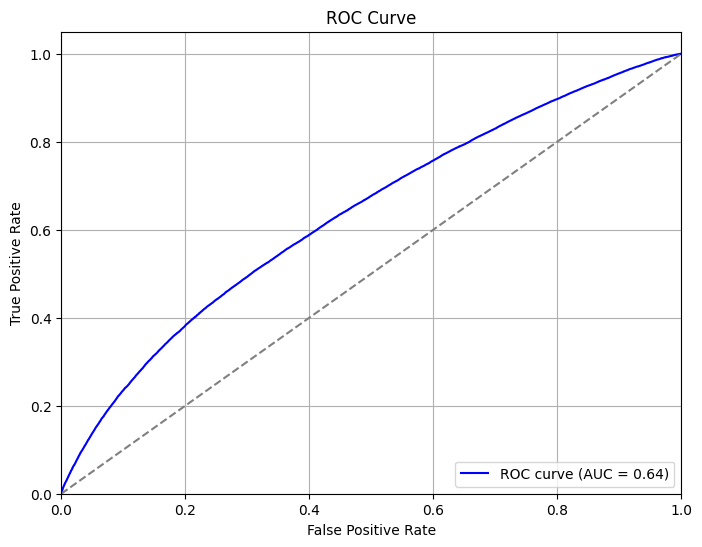

average acc, auc for test set: 0.6101827268467905, 0.6315078766032591


In [32]:
input_size = 13

model = LogRegModel(input_size)
train_data = better_shots_df.sample(frac=0.95)
acc, auc_scores, models = train(model,train_data,3)
correct,total,labels,probs = 0,0,[],[]
for model in models:
    c,t,p,l = validate(model,better_shots_df.drop(train_data.index),False,False,True)
    correct,total = correct+c,total+t
    labels.extend(l)
    probs.extend(p)
print(f"average acc, auc for test set: {correct/total}, {roc_auc_score(labels,probs)}")

In [12]:
input_size = 12

for var in ["CLOSEST_DEFENDER_PLAYER_ID","player_id","LOCATION","W","FINAL_MARGIN","SHOT_NUMBER","PERIOD","SHOT_CLOCK","DRIBBLES","TOUCH_TIME","SHOT_DIST","PTS_TYPE","CLOSE_DEF_DIST"]:
    model = LogRegModel(input_size)
    train_data = better_shots_df.sample(frac=0.95).drop(var,axis=1)
    print(f"dropped variable: {var}")
    _, _, models = train(model,train_data,3,print_roc_curve = False)
    correct,total,probs,labels = validate(models[random.randint(0,9)],better_shots_df.drop(var,axis=1).drop(train_data.index),False,False,True)
    print(f"acc, AUC on test set: {correct/total}, {roc_auc_score(labels,probs)}")
    print("-----------------------------")

dropped variable: CLOSEST_DEFENDER_PLAYER_ID
Average accuracy: 0.6169185767400174
Average AUC: 0.6391786290816638
acc, AUC on test set: 0.6140871466500079, 0.6436330293503771
-----------------------------
dropped variable: player_id
Average accuracy: 0.6106554056247822
Average AUC: 0.6272666623340897
acc, AUC on test set: 0.6012806496954552, 0.613526595034112
-----------------------------
dropped variable: LOCATION
Average accuracy: 0.6218006415214988
Average AUC: 0.6472325407123745
acc, AUC on test set: 0.6287677651101047, 0.6490534709145312
-----------------------------
dropped variable: W
Average accuracy: 0.6176909968525179
Average AUC: 0.6405436815931834
acc, AUC on test set: 0.6076838981727315, 0.6382154662396821
-----------------------------
dropped variable: FINAL_MARGIN
Average accuracy: 0.61843080732695
Average AUC: 0.6364399591727516
acc, AUC on test set: 0.6301733562392628, 0.644398713971881
-----------------------------
dropped variable: SHOT_NUMBER
Average accuracy: 0.622

In [ ]:
input_size = 1
variables = [
    "LOCATION","W","CLOSEST_DEFENDER_PLAYER_ID", "player_id", "FINAL_MARGIN", "SHOT_NUMBER", "PERIOD",
    "SHOT_CLOCK", "DRIBBLES", "TOUCH_TIME", "SHOT_DIST", "PTS_TYPE", "CLOSE_DEF_DIST"
]
acc,auc = [],[]
for var in variables:
    model = LogRegModel(input_size)
    train_data = better_shots_df.sample(frac=0.95)[[var,"FGM"]]
    print(f"variable: {var}")
    acc_scores, auc_scores, models = train(model,train_data,3,print_roc_curve = False)
    acc.append(sum(acc_scores)/len(acc_scores))
    auc.append(sum(auc_scores)/len(auc_scores))
    print("-----------------------------")

variable: LOCATION
Average accuracy: 0.5473754781007332
Average AUC: 0.503948583261057
-----------------------------
variable: W
Average accuracy: 0.5477043618724842
Average AUC: 0.5
-----------------------------
variable: CLOSEST_DEFENDER_PLAYER_ID
Average accuracy: 0.5813949624912148
Average AUC: 0.6060515005222891
-----------------------------
variable: player_id
Average accuracy: 0.5762580432884941
Average AUC: 0.5996204152880473
-----------------------------
variable: FINAL_MARGIN
Average accuracy: 0.5350961469540673
Average AUC: 0.5338624316904258
-----------------------------
variable: SHOT_NUMBER
Average accuracy: 0.5155590953185193
Average AUC: 0.4974685647492956
-----------------------------
variable: PERIOD
Average accuracy: 0.5150001011324388
Average AUC: 0.5076673611811133
-----------------------------
variable: SHOT_CLOCK
Average accuracy: 0.5585702459231501
Average AUC: 0.5517459173382082
-----------------------------
variable: DRIBBLES
Average accuracy: 0.52309573799259

In [42]:
for i in reversed(range(len(variables))):
    if auc[i]<0.505:
        variables.pop(i)
        acc.pop(i)
        auc.pop(i)

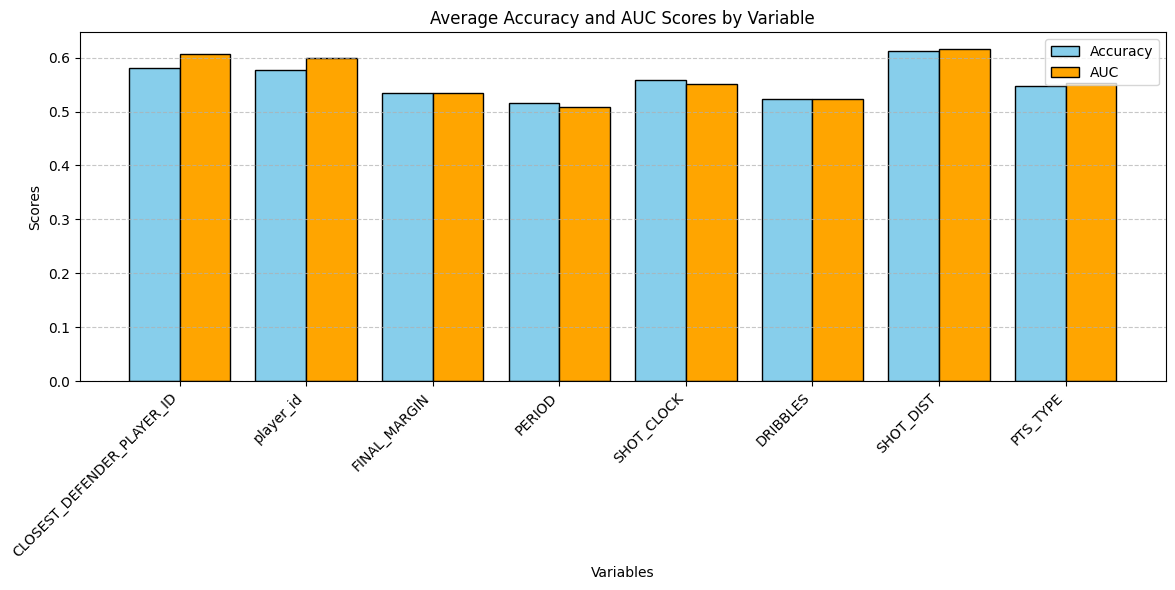

In [47]:
x = range(len(variables))
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.4
ax.bar(x, acc, width=bar_width, label="Accuracy", color="skyblue", edgecolor="black")
ax.bar([i + bar_width for i in x], auc, width=bar_width, label="AUC", color="orange", edgecolor="black")
ax.set_xticks([i + bar_width / 2 for i in x])
ax.set_xticklabels(variables, rotation=45, ha="right")
ax.set_ylabel("Scores")
ax.set_xlabel("Variables")
ax.set_title("Average Accuracy and AUC Scores by Variable")
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

Average accuracy: 0.6282939433180852
Average AUC: 0.6508077693578038


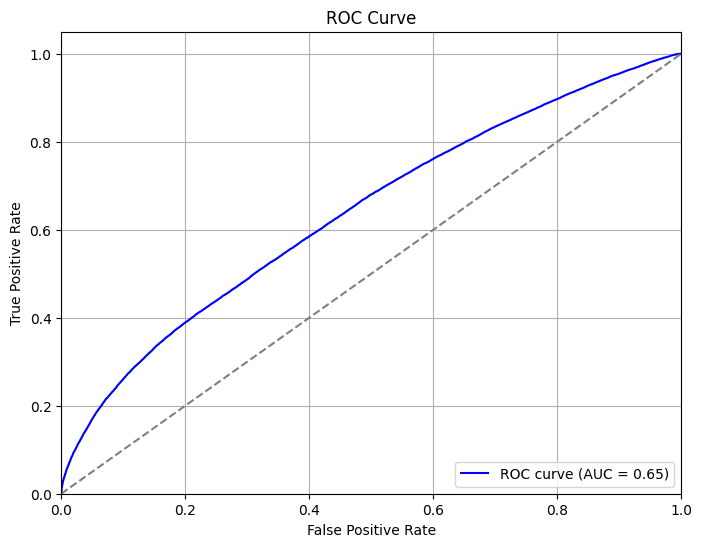

average acc, auc for test set: 0.6324066843667031, 0.6539802740508978


In [39]:
hidden_layer_size = 256
num_hidden_layers = 1
batch_size = 64
input_size = 13

model = DeepnnModel(input_size,hidden_layer_size,num_hidden_layers)
train_data = better_shots_df.sample(frac=0.95)

acc_scores,auc_scores,models = train(model,train_data,3)
correct,total,labels,probs = 0,0,[],[]
for model in models:
    c,t,p,l = validate(model,better_shots_df.drop(train_data.index),False,False,True)
    correct,total = correct+c,total+t
    labels.extend(l)
    probs.extend(p)
print(f"average acc, auc for test set: {correct/total}, {roc_auc_score(labels,probs)}")


In [29]:
input_size = 13
train_data = better_shots_df

total_acc = []
total_auc = []
for hidden_layer_size in [1,2,4,8,16,32,64,128,256]:
    hls_acc = []
    hls_auc = []
    for num_hidden_layers in range(9):
        model = DeepnnModel(input_size,hidden_layer_size,num_hidden_layers)
        print(f"# hidden layers: {num_hidden_layers}, # neurons/layer: {hidden_layer_size}")
        acc,auc_scores,_ = train(model,train_data,3,print_roc_curve=False)
        print("--------------------------------")
            
        hls_acc.append(sum(acc)/len(acc))
        hls_auc.append(sum(auc_scores)/len(auc_scores))
        
    total_acc.append(hls_acc)
    total_auc.append(hls_auc)
    

# hidden layers: 0, # neurons/layer: 1
Average accuracy: 0.6090779104884184
Average AUC: 0.6315976589612343
--------------------------------
# hidden layers: 1, # neurons/layer: 1
Average accuracy: 0.6222114372800064
Average AUC: 0.6413124715213965
--------------------------------
# hidden layers: 2, # neurons/layer: 1
Average accuracy: 0.603471542904394
Average AUC: 0.6351546061927796
--------------------------------
# hidden layers: 3, # neurons/layer: 1
Average accuracy: 0.562454530901902
Average AUC: 0.535616720534291
--------------------------------
# hidden layers: 4, # neurons/layer: 1
Average accuracy: 0.5569497190848149
Average AUC: 0.5278335102084405
--------------------------------
# hidden layers: 5, # neurons/layer: 1
Average accuracy: 0.5930241325520617
Average AUC: 0.5989422732327744
--------------------------------
# hidden layers: 6, # neurons/layer: 1
Average accuracy: 0.5856454419028247
Average AUC: 0.5773293159360844
--------------------------------
# hidden layers:

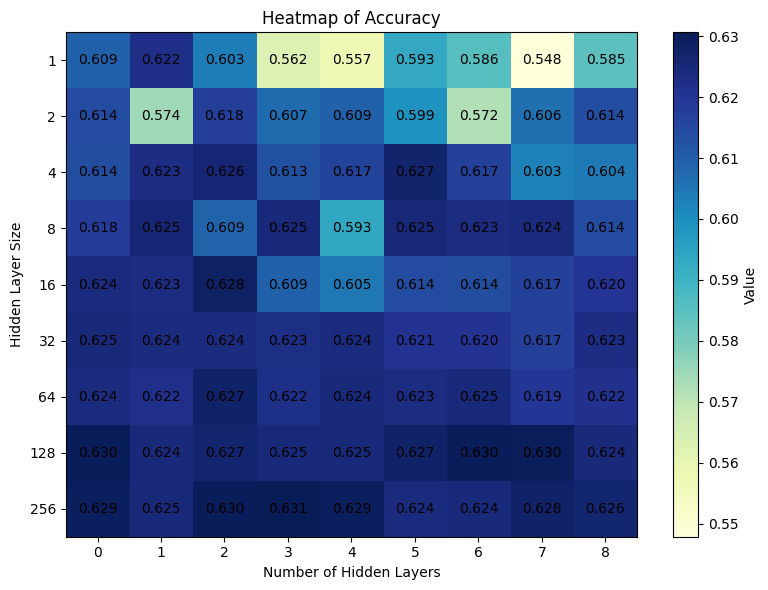

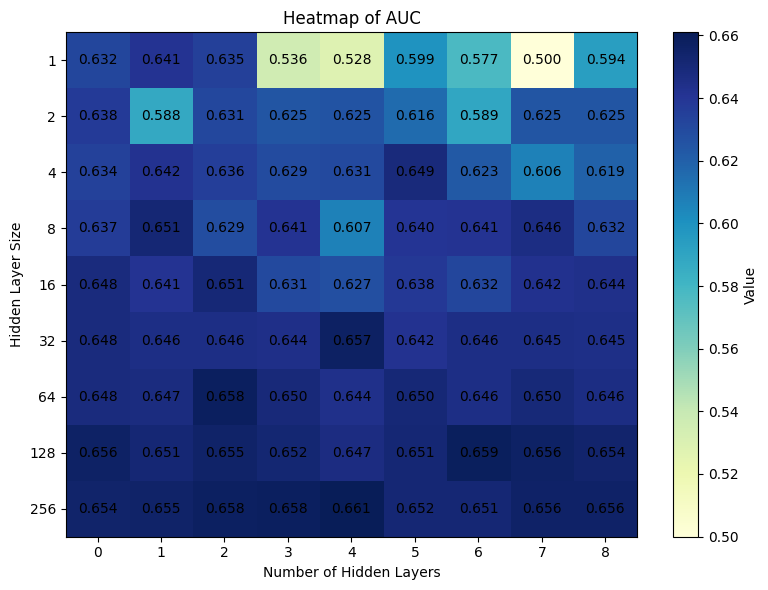

In [31]:
hidden_layer_sizes = [1,2,4,8,16,32,64,128,256]
num_hidden_layers = list(range(9))

total_acc_array = np.array(total_acc)
total_auc_array = np.array(total_auc)

def plot_heatmap(data, x_labels, y_labels, title, xlabel, ylabel):
    plt.figure(figsize=(8, 6))
    plt.imshow(data, cmap="YlGnBu", aspect="auto")
    plt.colorbar(label="Value")

    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            plt.text(j, i, f"{data[i, j]:.3f}", ha="center", va="center", color="black")

    plt.xticks(ticks=np.arange(len(x_labels)), labels=x_labels)
    plt.yticks(ticks=np.arange(len(y_labels)), labels=y_labels)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.tight_layout()
    plt.show()

# Plot heatmap for accuracy
plot_heatmap(total_acc_array, num_hidden_layers, hidden_layer_sizes, 
             "Heatmap of Accuracy", "Number of Hidden Layers", "Hidden Layer Size")

# Plot heatmap for AUC
plot_heatmap(total_auc_array, num_hidden_layers, hidden_layer_sizes, 
             "Heatmap of AUC", "Number of Hidden Layers", "Hidden Layer Size")
